In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
words = open("names.txt").read().splitlines()

In [3]:
vocab = ['.'] + sorted(list(set("".join(words))))

In [4]:
stoi = { ch:i for i,ch  in enumerate(vocab)}
itos = { i:ch for ch, i in stoi.items() }

In [5]:
stoi['a'], itos[1]

(1, 'a')

In [6]:
context_length = 3
g = torch.Generator().manual_seed(2147483647)

In [64]:
# visulize a 3d points as scatter plot
def plot_3d(encoding):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(C[:, 0].data, C[:, 1].data, C[:, 2].data, s=200)
    for i, enc in enumerate(C):
        ax.text(enc[0].item(), enc[1].item(), enc[2].item(), itos[i], ha="center", va="center", color="white")
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

In [7]:
# visulize a metrix as a scatter plot
def plot_metrix(encoding):
    plt.figure(figsize=(8,8))
    fig, ax = plt.subplots()
    ax.scatter(C[:, 0].data, C[:, 1].data, s=200)

    for i in range(C.shape[0]):
        ax.annotate(itos[i], (C[i, 0], C[i, 1]), ha="center", va="center", color="white")

In [8]:
def encode_words(words, context_length):
    inputs = []
    labels = []

    for word in words:
        word = word + '.'
        context = context_length * [0]
        for ch in word:
            inputs.append(context)
            labels.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    
    return inputs, labels

In [9]:
input_enc, label_enc = encode_words(words[:1], context_length)
for i in range(len(input_enc)):
    print(''.join(map(lambda ix: itos[ix], input_enc[i])), " --> ", itos[label_enc[i]])

...  -->  e
..e  -->  m
.em  -->  m
emm  -->  a
mma  -->  .


In [10]:
# split dataset into training, validation and test with 8:1:1 ratio
random.shuffle(words)
n1, n2 = int(len(words)*0.8), int(len(words)*0.1)
n3 = len(words) - n1 - n2
train_split = words[0:n1]
validation_split = words[n1:n1+n2]
test_split = words[n1+n2:n1+n2+n3]

In [11]:
input_dimensions = 3
hidden_layer_nurons_count = 300
# initialize multilayer perceptron
C = torch.randn((len(vocab), input_dimensions), generator=g) # 27 x input_dimensions
# input layer
W1 = torch.randn((context_length * input_dimensions, hidden_layer_nurons_count), generator=g) # because embedding is a tensor of dimenion 32 x 3 x input_dimensions for a batch of 32 inputs
b1 = torch.randn(hidden_layer_nurons_count, generator=g)
# output layer
W2 = torch.randn((hidden_layer_nurons_count, len(vocab)), generator=g) # because there are len(vocab) possible outcomes
b2 = torch.randn(len(vocab), generator=g)

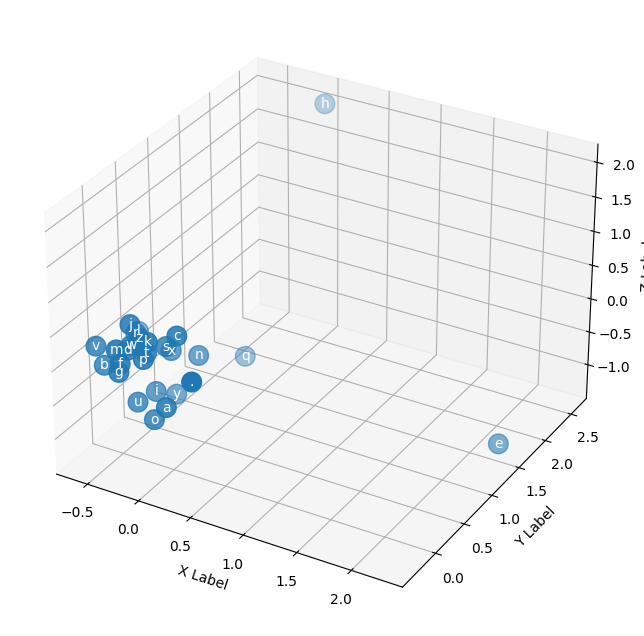

In [65]:
# visualize encodings before training
#plot_metrix(C)
if C.shape[1] == 3:
    plot_3d(C)
    
if C.shape[1] ==2:
    plot_metrix(C)

In [13]:
parameters = [C, W1, b1, W2, b2]
print("Number of parameters in the network", sum([p.nelement() for p in parameters]))

Number of parameters in the network 11208


In [16]:
for p in parameters:
    p.requires_grad=True

In [17]:
# generate 1000 exponentially increasesing learning rates
lre = np.linspace(-3, 0, 1000) # exponent
lrs = 10**lre

In [33]:
# train the network with training split
xs, ys = encode_words(train_split, context_length)
Xtr = torch.tensor(xs)
Ytr = torch.tensor(ys)
minibatch_size = 64

lossv = []
lri = []

for i in range(100000):
    # minibatch of 32 items
    ix = torch.randint(0, Xtr.shape[0], (minibatch_size,))
    minibatch = Xtr[ix]
    # forward
    emb = C[minibatch]
    # converting 32 x 3 x 10 into 32 x 30 using view for hidden layer multiplicaiton
    h = torch.tanh(emb.view((-1, input_dimensions * context_length)) @ W1 + b1) # figure out first dimensionl automatically
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward
    for param in parameters:
        param.grad = None

    loss.backward()
    # update weights
    lr = 0.1 if i < 50000 else 0.01
    # track lr  stats
    lri.append(i)
    lossv.append(loss.item())

    for p in parameters:
        p.data += -lr * p.grad

Text(0, 0.5, 'Loss value')

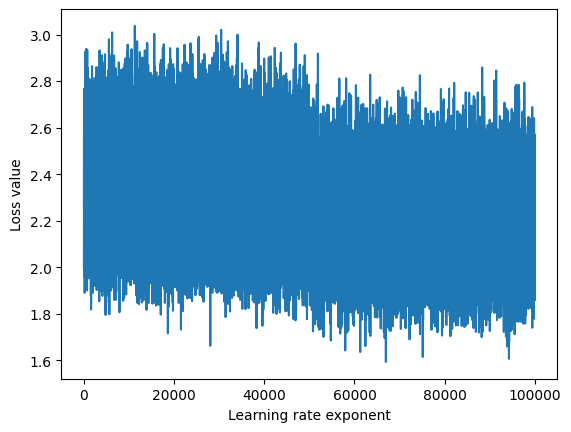

In [34]:
# plot lossx (index) vs lossy (loss value)
# from the first 1000 iteration we can see that the 
# loss is minimum around -1 ie 10^-1 = 0.1, 
# so 0.1 could be a good initial learning rate

plt.plot(lri, lossv)
plt.xlabel("Learning rate exponent")
plt.ylabel("Loss value")

In [35]:
# find loss for whole training split
emb = C[Xtr]
h = torch.tanh(emb.view((-1, input_dimensions * context_length)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1954, grad_fn=<NllLossBackward0>)

In [36]:
# find loss for validation split
xs, ys = encode_words(validation_split, context_length)
Xval, Yval = torch.tensor(xs), torch.tensor(ys)
emb = C[Xval]
h = torch.tanh(emb.view((-1, input_dimensions * context_length)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.2280, grad_fn=<NllLossBackward0>)

In [37]:
# find loss for test split
xs, ys = encode_words(test_split, context_length)
Xtest, Ytest = torch.tensor(xs), torch.tensor(ys)
emb = C[Xtest]
h = torch.tanh(emb.view((-1,input_dimensions * context_length)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytest)
loss

tensor(2.2208, grad_fn=<NllLossBackward0>)

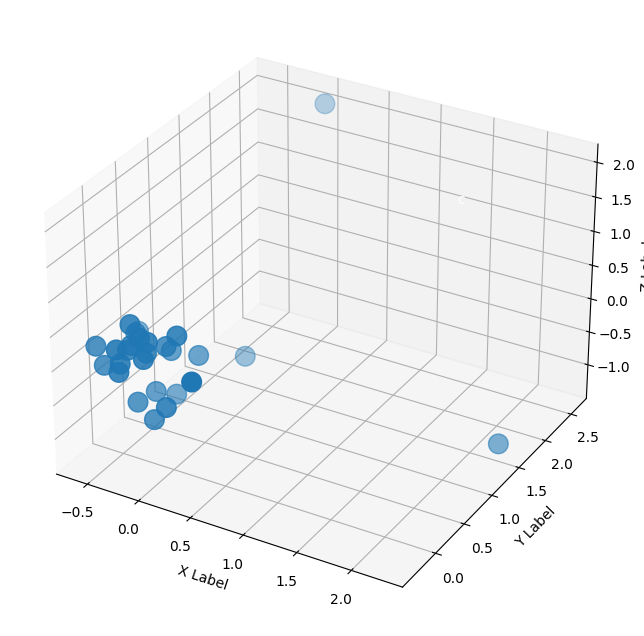

In [38]:
# visualize encodings after training
if C.shape[1] == 3:
    plot_3d(C)
    
if C.shape[1] ==2:
    plot_metrix(C)

In [36]:
# sampling from the model
def sample(number_of_samples):
    for _ in range(number_of_samples):
        out = []
        context = [0] * context_length
        while True:
            emb = C[torch.tensor([context])]
            h = torch.tanh(emb.view((-1, input_dimensions * context_length)) @ W1 + b1)  # -1 will figure out first dimension automatically
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            
            if ix == 0:
                break
                
            out.append(ix)
        print(''.join(itos[c] for c in out))

In [37]:
sample(10)

nayanialet
danlie
mihbe
chavaislitkarlyn
elyn
bryk
kera
dadina
nia
catean


In [87]:
def probability(word):
    xs, ys = encode_words([word], context_length)
    X, Y = torch.tensor(xs[1:]), torch.tensor(ys[1:])
    emb = C[X]    
    h = torch.tanh(emb.view((-1,input_dimensions * context_length)) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    likelihood = probs[torch.arange(X.shape[0]), Y]
    print(likelihood)
    p = likelihood.log().sum().exp()
    print("{0:.2f}%".format(p.item() * 100))

In [88]:
probability("emma")

tensor([0.2101, 0.0883, 0.3255, 0.2649], grad_fn=<IndexBackward0>)
0.16%


[1, 0]